# <span style="color:green"> Numerical Simulation Laboratory </span>
## <span style="color:brown"> Python Exercise 12 </span>
## <span style="color:orange"> Keras - Deep & Convolutional Neural Network image recognition </span>

### MNIST with Keras

The goal of exercise 12 is to use deep neural network models, implemented in the Keras python package, to recognize and distinguish between the ten handwritten digits (0-9).

The MNIST dataset comprises $70000$ handwritten digits, each of which comes in a square image, divided into a $28\times 28$ pixel grid. Every pixel can take on $256$ gradation of the gray color, interpolating between white and black, and hence each data point assumes any value in the set $\{0,1,\dots,255\}$. Since there are $10$ categories in the problem, corresponding to the ten digits, this problem represents a generic **classification task**. 

In [24]:
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True' #This is needed in my Anaconda+MacOsX installation; leave it commented.
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

#### Step 1: Load and Process the Data

Keras can conveniently download the MNIST data from the web. All we need to do is import the `mnist` module and use the `load_data()` class, and it will create the training and test data sets or us.

The MNIST set has pre-defined test and training sets, in order to facilitate the comparison of the performance of different models on the data.

Once we have loaded the data, we need to format it in the correct shape.

In [34]:
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)


#### Example: to_categorical

Converts a class vector (integers) to binary class matrix. E.g. for use with categorical_crossentropy.

In [26]:
# Consider an array of 5 labels out of a set of 3 classes {0, 1, 2}:
labels = np.array([0, 2, 1, 2, 0])
# `to_categorical` converts this into a matrix with as many columns as there are classes.
# The number of rows stays the same.
keras.utils.to_categorical(labels)

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

#### Reshape data and convert labels to be used with categorical cross entropy

X_train shape: (60000, 784)
X_test shape: (10000, 784)

an example of a data point with label 4


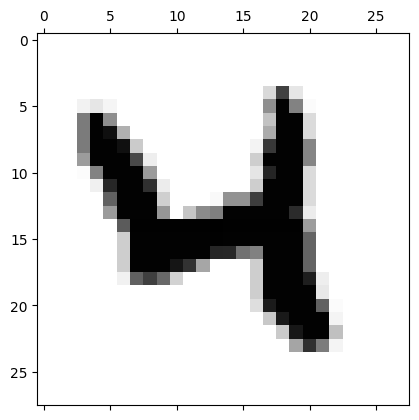

... and with label [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] after to_categorical

X_train shape: (60000, 784)
Y_train shape: (60000, 10)


In [35]:
# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print()

# cast to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# look at an example of data point
print('an example of a data point with label', Y_train[20])
# matshow: display a matrix in a new figure window
plt.matshow(X_train[20,:].reshape(28,28),cmap='binary')
plt.show()

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('... and with label', Y_train[20], 'after to_categorical')
print()
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

#### Step 2: Define the Neural Net and its Architecture

We can now move on to construct our deep neural net. We shall use Keras's `Sequential()` class to instantiate a model, and will add different deep layers one by one using the `add()` method

For the purposes of our example, it suffices to focus on `Dense` layers for simplicity. Every `Dense()` layer accepts as its first required argument an integer which specifies the number of neurons. The type of activation function for the layer is defined using the `activation` optional argument, the input of which is the name of the activation function in `string` format. Examples include `relu`, `tanh`, `elu`, `sigmoid`, `softmax`. 

In order for our DNN to work properly, we have to make sure that the numbers of input and output neurons for each layer match. Therefore, we specify the shape of the input in the first layer of the model explicitly using the optional argument `input_shape=(N_features,)`. The sequential construction of the model then allows Keras to infer the correct input/output dimensions of all hidden layers automatically. Hence, we only need to specify the size of the softmax output layer to match the number of categories.

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

print('Model architecture created successfully!')

Model architecture created successfully!


#### Step 3: Choose the Optimizer and the Cost Function

Next, we choose the loss function according to which to train the DNN. For classification problems, this is the cross entropy, and since the output data was cast in categorical form, we choose the `categorical_crossentropy` defined in Keras' `losses` module. Depending on the problem of interest one can pick any other suitable loss function. To optimize the weights of the net, we choose SGD. This algorithm is already available to use under Keras' `optimizers` module, but we could use any other built-in one as well. The parameters for the optimizer, such as `lr` (learning rate) or `momentum` are passed using the corresponding optional arguments of the `SGD()` function. All available arguments can be found in Keras' online documentation at [https://keras.io/](https://keras.io/). While the loss function and the optimizer are essential for the training procedure, to test the performance of the model one may want to look at a particular `metric` of performance. For instance, in categorical tasks one typically looks at their `accuracy`, which is defined as the percentage of correctly classified data points. To complete the definition of our model, we use the `compile()` method, with optional arguments for the `optimizer`, `loss`, and the validation `metric` as follows:

In [36]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

def compile_model():
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adam(),
                  metrics=['acc'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


#### Step 4: Train the model

We train our DNN in minibatches. 

Shuffling the training data during training improves stability of the model. Thus, we train over a number of training epochs. Each epoch corresponds to using **all the train data** divided in minibatches.

Training the DNN is a one-liner using the `fit()` method of the `Sequential` class. The first two required arguments are the training input and output data. As optional arguments, we specify the mini-`batch_size`, the number of training `epochs`, and the test or `validation_data`. To monitor the training procedure for every epoch, we set `verbose=True`. 

In [37]:
# training parameters
batch_size = 32
epochs = 5

# create the deep neural net
model_DNN = compile_model()

# train DNN and store training info in history
history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - acc: 0.8575 - loss: 0.4746 - val_acc: 0.9645 - val_loss: 0.1128
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - acc: 0.9616 - loss: 0.1379 - val_acc: 0.9733 - val_loss: 0.0885
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - acc: 0.9734 - loss: 0.0941 - val_acc: 0.9760 - val_loss: 0.0842
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - acc: 0.9794 - loss: 0.0697 - val_acc: 0.9779 - val_loss: 0.0798
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - acc: 0.9818 - loss: 0.0598 - val_acc: 0.9795 - val_loss: 0.0756


#### Step 5: Evaluate the Model Performance on the *Unseen* Test Data

Next, we evaluate the model and read of the loss on the test data, and its accuracy using the `evaluate()` method.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9441 - loss: 0.1854

Test loss: 0.15872474014759064
Test accuracy: 0.9527000188827515


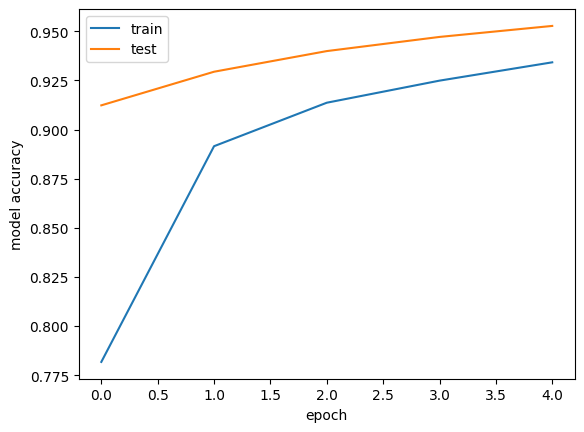

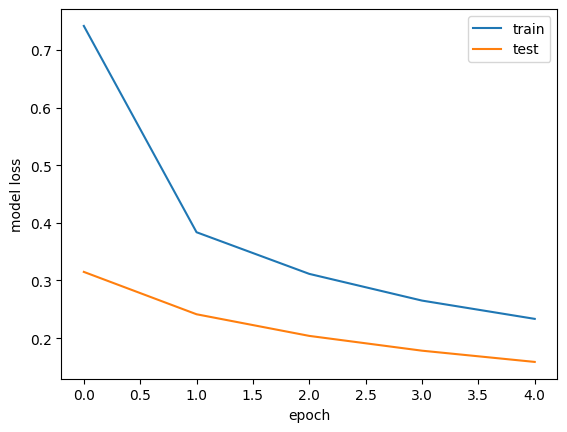

In [8]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

Dropout, during training, slices off some artificial neurons, thus, training accuracy suffers.

Dropout, during testing, turns itself off and allows all of the ‘weak classifiers’ in the neural network to be used. Thus, testing accuracy improves with respect to training accuracy.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


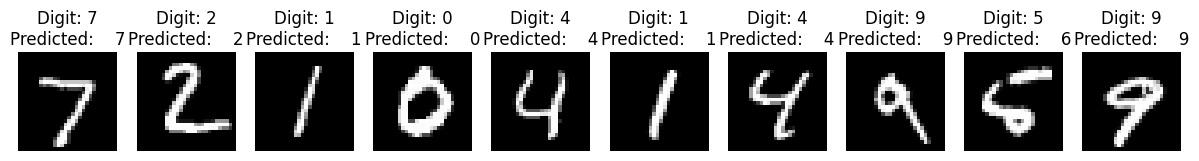

In [9]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_DNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:    {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

### Exercise 12.1

<span style="color:red">Change at will and train your DNN by increasing the number of epochs to an adeuqate value</span>. Try to use at least two other optimizers, different from SGD: <span style="color:red">watch to accuracy and loss for training and validation data and comment on the performances</span>.



#### Creating Convolutional Neural Nets with Keras

We have so far considered each MNIST data sample as a $(28\times 28,)$-long 1d vector. On the other hand, we do know that in every one of the hand-written digits there are *local* spatial correlations between the pixels, but also *translational invariance*, which we would like to take advantage of to improve the accuracy of our classification model. To this end, we first need to reshape the training and test input data as follows

In [42]:
# you will need the following for Convolutional Neural Networks
from keras.layers import Flatten, Conv2D, MaxPooling2D

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':   # channel is 3 for RGB image (60000, 3, 28, 28)
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:   # (60000, 28, 28, 3)
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


One can ask the question of whether a neural net can learn to recognize such local patterns. This can be achieved by using convolutional layers.

### Exercise 12.2

Change the architecture of your DNN using convolutional layers. Use `Conv2D`, `MaxPooling2D`, `Dropout`, but also do not forget `Flatten`, a standard `Dense` layer and `soft-max` in the end. I have merged step 2 and 3 in the following definition of `create_CNN()` that **<span style="color:red">you should complete</span>**:

In [14]:
#THIS IS INCOMPLETE ... COMPLETE BEFORE EXECUTING IT

def create_CNN():
    # instantiate model
    model = Sequential()
    # add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(10, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=input_shape))
    #
    # ADD HERE SOME OTHER LAYERS AT YOUR WILL, FOR EXAMPLE SOME: Dropout, 2D pooling, 2D convolutional etc. ... 
    # remember to move towards a standard flat layer in the final part of your DNN,
    # and that we need a soft-max layer with num_classes=10 possible outputs
    #
    
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='SGD',
                  metrics=['acc'])
    return model

Train your DCNN and evaluate its performance proceeding exactly as before:

In [ ]:
# training parameters
batch_size = 32
epochs = # INSERT HERE AN ADEQUATE NUMBER OF EPOCHS!

# create the deep conv net
model_CNN=create_CNN()

# train CNN
model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

# evaliate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In the end, **<span style="color:red">add the evaluation of your CNN performances</span>** like that used for the DNN.



### Exercise 12.3

Use the `gimp` application to create 10 pictures of your "handwritten" digits, import them in your jupyter-notebook and try to see if your CNN is able to recognize your handwritten digits.

For example, you can use the following code to import a picture of an handwritten digit
(Note: you should install Python Image Library (PIL/Pillow):

In [ ]:
# TO LOAD FILES ON GOOGLE COLAB
#from google.colab import files
#upload = files.upload() #this will let you browse and choose the file to be uploaded

## Solution

In [115]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
import time

plt.rcParams.update({'font.size': 22})

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import SGD, Adam, RMSprop
from keras.datasets import mnist

seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [116]:
# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

# cast to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

### Exercise 12.1

In [117]:
# Function to create the DNN model
def create_DNN():
    model = Sequential()
    model.add(Dense(400, input_shape=(img_rows * img_cols,), activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Training parameters
batch_size = 32
epochs = 15
optimizers = {
    'SGD': SGD(),
    'Adam': Adam(),
    'RMSprop': RMSprop()
}

histories = {}

# Train a model for each optimizer and measure the time taken
for name, opt in optimizers.items():
    model = create_DNN()
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    print(f"\nTraining with {name}...")
    start_time = time.time()  
    callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            patience=4,
                                            restore_best_weights = True)
    history = model.fit(
        X_train, Y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks = [callback],
        verbose=1,
        shuffle=True,
        validation_data=(X_test, Y_test)
    )
    
    end_time = time.time()  
    elapsed_time = end_time - start_time
    print(f"Training with {name} completed in {elapsed_time:.2f} seconds.")
    
    histories[name] = history



Training with SGD...
Epoch 1/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.6468 - loss: 1.1480 - val_accuracy: 0.9122 - val_loss: 0.3139
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8824 - loss: 0.4115 - val_accuracy: 0.9294 - val_loss: 0.2419
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9100 - loss: 0.3236 - val_accuracy: 0.9400 - val_loss: 0.2050
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9205 - loss: 0.2766 - val_accuracy: 0.9451 - val_loss: 0.1806
Epoch 5/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9318 - loss: 0.2443 - val_accuracy: 0.9515 - val_loss: 0.1601
Epoch 6/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9383 - loss: 0.2223 - val_accuracy: 0.9549 - val_loss: 0.1458
Epoch 7/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9461 - loss: 0.1943 - val_accuracy: 0.9593 - val_loss: 0.1321
Epoch 8/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - acc

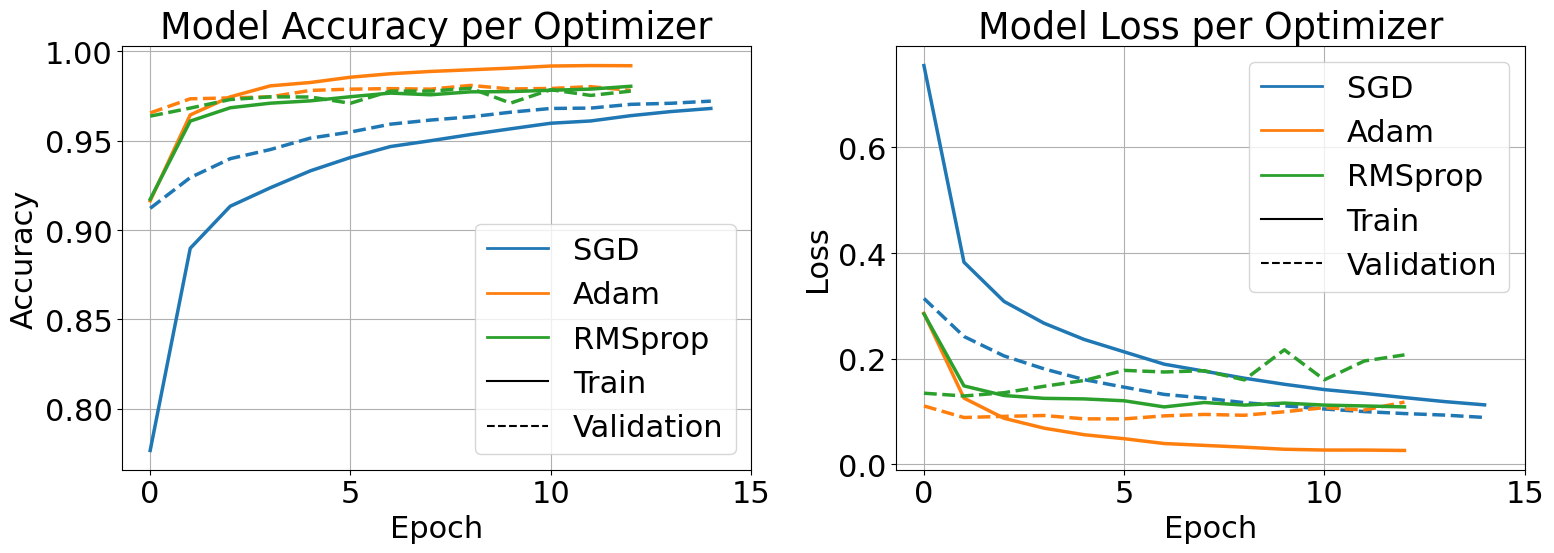

In [118]:
import matplotlib.lines as mlines

colors = {
    'SGD': 'tab:blue',
    'Adam': 'tab:orange',
    'RMSprop': 'tab:green'
}


fig, ax = plt.subplots(1, 2, figsize=(16, 6))

xticks = [0, 5, 10, 15]

# Accuracy plot
for name, history in histories.items():
    ax[0].plot(history.history['accuracy'], color=colors[name], label=f'{name} - train', linewidth=2.5)
    ax[0].plot(history.history['val_accuracy'], color=colors[name], linestyle='--', label=f'{name} - val', linewidth=2.5)

ax[0].set_title('Model Accuracy per Optimizer')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_xticks(xticks)
ax[0].grid(True)

# Loss plot
for name, history in histories.items():
    ax[1].plot(history.history['loss'], color=colors[name], label=f'{name} - train', linewidth=2.5)
    ax[1].plot(history.history['val_loss'], color=colors[name], linestyle='--', label=f'{name} - val', linewidth=2.5)

ax[1].set_title('Model Loss per Optimizer')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_xticks(xticks)
ax[1].grid(True)

# two legend: color and linestyle
optimizer_handles = [mlines.Line2D([], [], color=color, linewidth=2, label=name) for name, color in colors.items()]
style_handles = [
    mlines.Line2D([], [], color='black', linestyle='-', label='Train'),
    mlines.Line2D([], [], color='black', linestyle='--', label='Validation')
]

# leg1 = ax[0].legend(handles=optimizer_handles, title='Optimizers', loc='upper left')
# leg2 = ax[0].legend(handles=style_handles, title='Type', loc='lower right')
# ax[0].add_artist(leg1)  # Mantieni entrambe le legende
ax[0].legend(handles=optimizer_handles + style_handles, loc='lower right')


# Copia anche le legende nel secondo plot
ax[1].legend(handles=optimizer_handles + style_handles, loc='upper right')

plt.tight_layout()
plt.show()


I trained the model using SGD, Adam, and RMSprop optimizers for 15 epochs. Below is a summary of the results based on the provided plots of accuracy and loss:

- Adam achieves the highest validation accuracy, converging close to 98% by the end of training.
- RMSprop follows closely but with slightly more fluctuations in the validation curve.
- SGD improves steadily but lags behind the other two, ending around 97% validation accuracy.

Since this is a classification problem, I applied early stopping based on validation accuracy instead of loss, as improving accuracy is the primary goal here. Both Adam and RMSprop stopped early after 13 epochs thanks to early stopping, while SGD completed all 15 epochs.

In terms of computational performance:

- Training with RMSprop completed in 208.97 seconds (13 epochs, ~16.07 s/epoch).
- Training with Adam completed in 222.29 seconds (13 epochs, ~17.10 s/epoch).
- Training with SGD completed in 231.84 seconds (15 epochs, ~15.46 s/epoch).

Although Adam is slightly slower per epoch than the others, the superior accuracy and generalization make the extra time worthwhile.

Conclusion: Adam is the best performing optimizer for this model, offering the highest accuracy and generalization. Although slightly slower per epoch, it’s the recommended choice when model performance is more important than training speed. SGD and RMSprop remain good alternatives but may require longer training and careful tuning to match Adam’s results.



### Exercise 12.2

For this exercise, I implemented and trained a Convolutional Neural Network (CNN) to improve image classification performance compared to the previous DNN.

#### CNN Architecture:

- **Conv2D Layer 1**: 
  - 10 filters, kernel size (3x3)
  - Activation: ReLU
  - MaxPooling2D (2x2)

- **Conv2D Layer 2**:
  - 64 filters, kernel size (3x3)
  - Activation: ReLU
  - MaxPooling2D (2x2)

- **Dropout**: 0.25

- **Flatten Layer**

- **Dense Layer**: 
  - 128 neurons
  - Activation: ReLU
  - Dropout: 0.5

- **Output Layer**:
  - Number of neurons = number of classes
  - Activation: softmax

- **Loss Function**: categorical_crossentropy  
- **Optimizer**: Adam


#### Training

- Epochs: 15  
- Batch size: 32  
- Validation: Evaluation on the test dataset after each epoch


In [119]:
def create_CNN():
    model = Sequential()
    
    # First Conv2D layer
    model.add(Conv2D(10, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Second Conv2D layer
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Dropout for regularization
    model.add(Dropout(0.25))
    
    # Flatten before Dense layers
    model.add(Flatten())
    
    # Fully connected Dense layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),  
                  metrics=['accuracy'])
    
    return model

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':   # channel is 3 for RGB image (60000, 3, 28, 28)
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:   # (60000, 28, 28, 3)
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    

# Training parameters
batch_size = 32
epochs = 15 

# Create CNN
model_CNN = create_CNN()

start_time = time.time()
# Train CNN
history = model_CNN.fit(X_train, Y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(X_test, Y_test))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

# Evaluate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.8520 - loss: 0.4789 - val_accuracy: 0.9807 - val_loss: 0.0571
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.9678 - loss: 0.1096 - val_accuracy: 0.9877 - val_loss: 0.0366
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.9763 - loss: 0.0787 - val_accuracy: 0.9890 - val_loss: 0.0344
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.9807 - loss: 0.0663 - val_accuracy: 0.9890 - val_loss: 0.0339
Epoch 5/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.9831 - loss: 0.0553 - val_accuracy: 0.9913 - val_loss: 0.0272
Epoch 6/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.9861 - loss: 0.0441 - val_accuracy: 0.9922 - val_loss: 0.0251
Epoch 7/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.9860 - loss: 0.0446 - val_accuracy: 0.9920 - val_loss: 0.0264
Epoch 8/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.9872 -

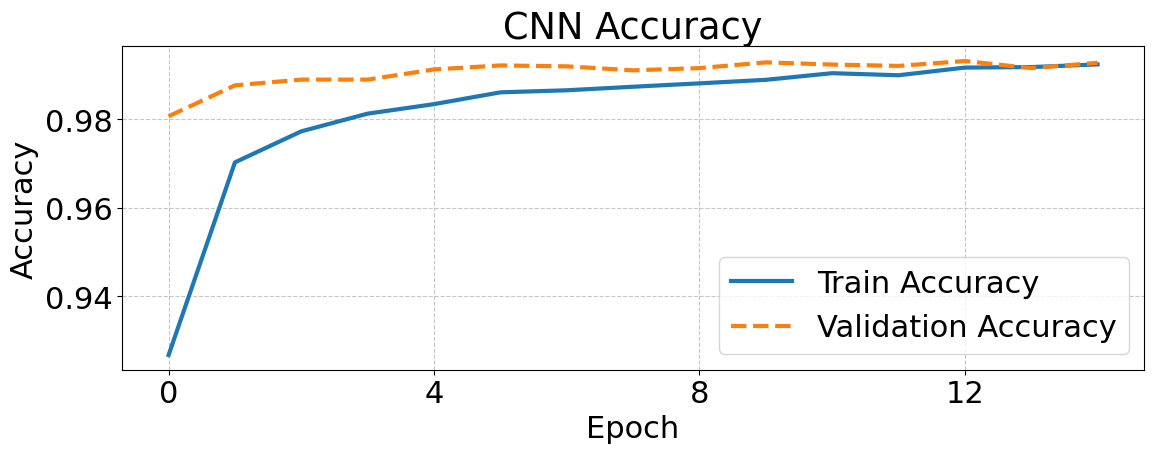

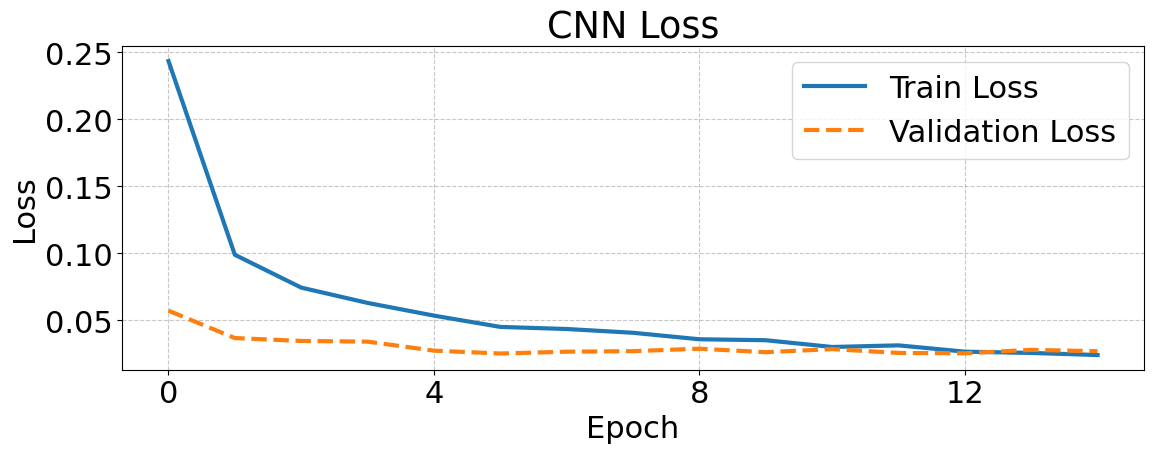

In [120]:
xticks = [0, 4, 8, 12]

plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='tab:blue', linewidth=3)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='tab:orange', linestyle='--', linewidth=3)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Accuracy')
plt.xticks(xticks)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss', color='tab:blue', linewidth=3)
plt.plot(history.history['val_loss'], label='Validation Loss', color='tab:orange', linestyle='--', linewidth=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN Loss')
plt.xticks(xticks)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


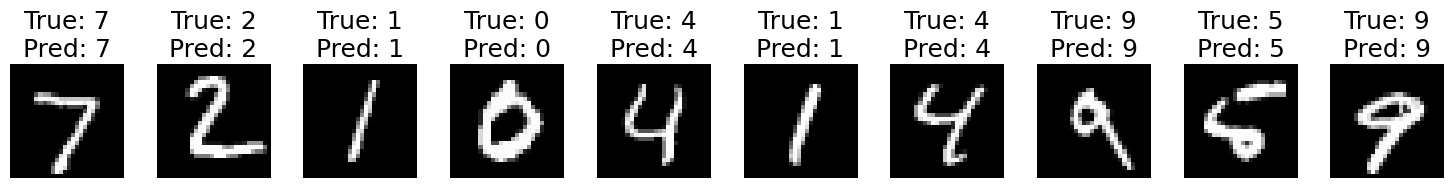

In [110]:
predictions = model_CNN.predict(X_test)

plt.figure(figsize=(15, 5))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(X_test[i, :, :, 0], cmap='gray')
    plt.title(f"True: {np.argmax(Y_test[i])}\nPred: {np.argmax(predictions[i])}", fontsize = 18)
    plt.axis('off')
plt.tight_layout()
plt.show()

#### Results

The CNN significantly outperforms the DNN, showing that convolutional layers are much more effective at capturing the spatial structure of image data.
I achive a train and validation accuracy both higher than 99\%. 
Although the training time is longer, 15 epoches in 385 seconds, the performance gain is substantial.  
CNNs provide better generalization, robustness, and higher accuracy for image classification tasks compared to fully connected DNNs.


### Exercise 12.3



After training the Convolutional Neural Network (CNN), I decided to perform an additional test by writing digits myself using the program `gimp`. 
I created 10 images, each representing a digit from 0 to 9, and saved them in the directory `Pictures/` in .png format.


For each handwritten digit:
- The image was converted to grayscale
- Resized to 28x28 pixels to match the input size of the CNN.
- Normalized (pixel values scaled to the range $[0, 1]$).


These preprocessed images were then passed to the trained CNN for prediction. The CNN successfully predicted all the handwritten digits correctly, even though they were written by me and not part of the training dataset.

This demonstrates that the model has strong generalization capabilities and is capable of recognizing handwritten digits that differ from the original dataset style.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


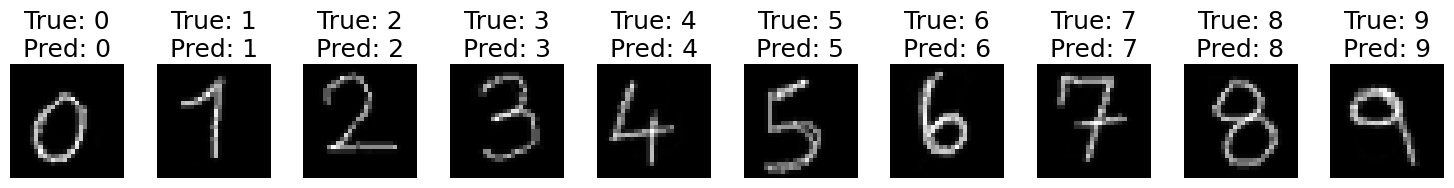

In [124]:
from PIL import Image
import os

images = []

for i in range(10):
    digit_filename = f"Pictures/{i}.png"
    digit_in = Image.open(digit_filename).convert('L')
    
    digit_in = digit_in.resize((28, 28))  # Assicuriamoci che sia 28x28
    
    data = np.array(digit_in) / 255.0     # Converti direttamente in array numpy normalizzato
    images.append(data)

images = np.array(images)  # Shape: (10, 28, 28)

images = images.reshape(images.shape[0], img_rows, img_cols, 1)
predictions = model_CNN.predict(images)
labels = np.array([0,1,2,3,4,5,6,7,8,9])
labels_onehot = keras.utils.to_categorical(labels, num_classes=10)

plt.figure(figsize=(15, 5))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(images[i, :, :, 0], cmap='gray')
    plt.title(f"True: {np.argmax(labels_onehot[i])}\nPred: {np.argmax(predictions[i])}", fontsize = 18)
    plt.axis('off')
plt.tight_layout()
plt.show()

### <span style="color:green">Supplementary information 1: Use of `gimp` </span>

- from the Unix shell type: `gimp` and hit `Return`
- File -> new (chose: 28x28 pixels)
- rascale the image to 800%
- Use the **brush** with dimension 2px to draw your digit
- Color -> invert (to have black background)
- Export the image as a `.png` file

That's all!

### <span style="color:green">Supplementary information 2: Display trained filters in your CNN</span>

Print your NN layers:

In [49]:
layer_index=0
for layer in model_CNN.layers:
    print(layer_index, layer.name)
    layer_index+=1

0 conv2d_4
1 max_pooling2d_4
2 conv2d_5
3 max_pooling2d_5
4 dropout_9
5 flatten_2
6 dense_19
7 dropout_10
8 dense_20


Display your filters:

(3, 3, 1, 10)


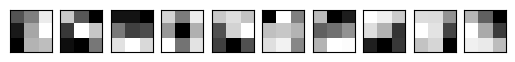

In [39]:
# layer_index should be the index of a convolutional layer
layer_index=0
# retrieve weights from the convolutional hidden layer
filters, biases = model_CNN.layers[layer_index].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
print(filters.shape)

# plot filters
n_filters, ix = filters.shape[3], 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # specify subplot and turn of axis
    ax = plt.subplot(1,n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    plt.imshow(f[:, :, 0], cmap='gray')
    ix += 1
# show the figure
plt.show()